In [ ]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5934, done.
remote: Total 5934 (delta 0), reused 0 (delta 0), pack-reused 5934
Receiving objects: 100% (5934/5934), 6.35 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (3925/3925), done.


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-04-18 16:01:31--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  79.6MB/s    in 3.0s    

2021-04-18 16:01:34 (79.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
yolo_weights = '/content/yolov3.weights'
yolo_cfg = '/content/darknet/cfg/yolov3.cfg'
coco_names = '/content/darknet/data/coco.names'
confidence_threshold = 0.6
nms_threshold = 0.5

In [ ]:
import cv2
import time
import argparse
import numpy as np


def load_input_image(image_path):
    test_img = cv2.imread(image_path)
    h, w, _ = test_img.shape

    return test_img, h, w


def yolov3(yolo_weights, yolo_cfg, coco_names):
    net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
    classes = open(coco_names).read().strip().split("\n")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return net, classes, output_layers


def perform_detection(net, img, output_layers, w, h, confidence_threshold):
    blob = cv2.dnn.blobFromImage(img, 1 / 255., (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []
    x = []
    y = []
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Object is deemed to be detected
            if confidence > confidence_threshold:
                # center_x, center_y, width, height = (detection[0:4] * np.array([w, h, w, h])).astype('int')
                center_x, center_y, width, height = list(map(int, detection[0:4] * [w, h, w, h]))
                # print(center_x, center_y, width, height)

                top_left_x = int(center_x - (width / 2))
                top_left_y = int(center_y - (height / 2))

                boxes.append([top_left_x, top_left_y, width, height])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                x.append(center_x)
                y.append(center_y)

    return  x, y, boxes, confidences, class_ids


def draw_boxes(boxes, confidences, class_ids, classes, img, colors, confidence_threshold, NMS_threshold):

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, NMS_threshold)

    FONT = cv2.FONT_HERSHEY_SIMPLEX

    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            # print(len(colors[class_ids[i]]))
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            # text = f"{class_ids[i]} -- {confidences[i]}"
            text = "{}: {:.4f}".format(classes[class_ids[i]], confidences[i])
            cv2.putText(img, text, (x, y - 5), FONT, 0.5, color, 2)
    
    cv2_imshow(img)
    return img


def dectection_video_file(webcam, video_path, yolo_weights, yolo_cfg, coco_names, confidence_threshold, nms_threshold):
    net, classes, output_layers = yolov3(yolo_weights, yolo_cfg, coco_names)
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    if webcam:
        video = cv2.VideoCapture(0)
        time.sleep(2.0)
    else:
        video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
    out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))
    while True:
        ret, image = video.read()
        if ret == True:
          h, w, _ = image.shape
          center_x, center_y, boxes, confidences, class_ids = perform_detection(net, image, output_layers, w, h, confidence_threshold)
          img = draw_boxes(boxes, confidences, class_ids, classes, image, colors, confidence_threshold, nms_threshold)
          out.write(img)
          key = cv2.waitKey(1) & 0xFF
          if key == ord("q"):
            break
        else:
          break

    video.release()
    out.release()
    cv2.destroyAllWindows()

def detection_image_file(image_path, yolo_weights, yolo_cfg, coco_names, confidence_threshold, nms_threshold):
    img, h, w = load_input_image(image_path)
    net, classes, output_layers = yolov3(yolo_weights, yolo_cfg, coco_names)
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    x, y, boxes, confidences, class_ids = perform_detection(net, img, output_layers, w, h, confidence_threshold)
    draw_boxes(boxes, confidences, class_ids, classes, img, colors, confidence_threshold, nms_threshold)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


    

In [ ]:
def draw_person_boxes(boxes, confidences, class_ids, classes, img, colors, confidence_threshold, NMS_threshold):

    FONT = cv2.FONT_HERSHEY_SIMPLEX

    for i in range(len(boxes)):
            x, y, w, h = boxes[i]
            # print(len(colors[class_ids[i]]))
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            # text = f"{class_ids[i]} -- {confidences[i]}"
    
    return img

In [15]:
import math
def social_dist(webcam, video_path, yolo_weights, yolo_cfg, coco_names, confidence_threshold, nms_threshold):
    net, classes, output_layers = yolov3(yolo_weights, yolo_cfg, coco_names)
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    if webcam:
        video = cv2.VideoCapture(0)
        time.sleep(2.0)
    else:
        video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
    out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))
    while True:
        ret, image = video.read()
        if ret == True:
          h, w, _ = image.shape
          x, y, boxes, confidences, class_ids = perform_detection(net, image, output_layers, w, h, confidence_threshold)
          indexes = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
          person_ids = []
          person_boxes = []
          if len(indexes) > 0:
            for i in indexes.flatten():
              if classes[class_ids[i]] == 'person':
                person_ids.append(class_ids)
                person_boxes.append(boxes[i])

          img = draw_person_boxes(person_boxes, confidences, class_ids, classes, image, colors, confidence_threshold, nms_threshold)
          visited = []
          if len(person_ids)>0:
            for i in range(len(person_ids)):
              if i not in visited:
                visited.append(i)
                mean_x = x[i]
                mean_y = y[i]
                cluster = 1
                for j in range(len(person_ids)):
                  if j not in visited:
                    dist = math.sqrt((mean_x - x[j])*(mean_x - x[j])+(mean_y - y[j])*(mean_y - y[j]))
                    if dist < 60:
                      visited.append(j)
                      mean_x = (mean_x * cluster + x[j])/(cluster+1)
                      mean_y = (mean_y * cluster + y[j])/(cluster+1)
                      cluster+=1
                if cluster > 1:
                  color = (0,0,255)
                  c1 = int(mean_x)
                  c2 = int(mean_y)
                  r = 50
                  cv2.circle(img, (c1,c2 ), r, color, 2)
           
                  text = "{} Persons in radius: {:.4f}".format(cluster, 60)
                  cv2.putText(img, text, (c1-r, c2-r), FONT, 0.5, color, 2)

          from IPython.display import clear_output
          clear_output()
          cv2_imshow(img)
          out.write(img)
          key = cv2.waitKey(1) & 0xFF
          if key == ord("q"):
            break
        else:
          break

    video.release()
    out.release()
    cv2.destroyAllWindows()

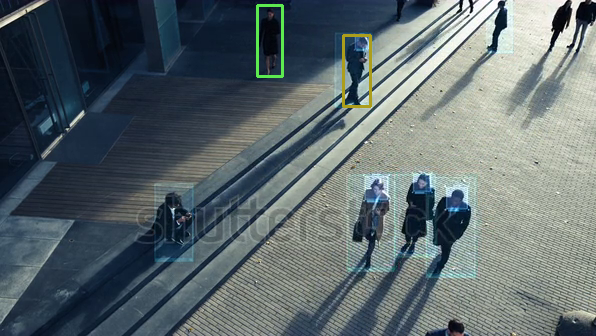

In [16]:
video_path = '/content/1056263537-preview.mp4'
webcam = False
social_dist(webcam, video_path, yolo_weights, yolo_cfg, coco_names, confidence_threshold, nms_threshold)

In [ ]:
video_path = '/content/0447.avi'
webcam = False
dectection_video_file(webcam, video_path, yolo_weights, yolo_cfg, coco_names, confidence_threshold, nms_threshold)